In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import (
    ExtraTreesRegressor, 
    RandomForestRegressor, 
    AdaBoostRegressor, 
    HistGradientBoostingRegressor,
    GradientBoostingRegressor )

from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error

In [2]:
trainData = pd.read_csv('../data/train.csv')
testData = pd.read_csv('../data/test.csv')
_1 = pd.read_csv('../data/addData1.csv')
_2 = pd.read_csv('../data/addData2.csv')
_3 = pd.read_csv('../data/addData3.csv')

print('Before:',trainData.shape)
trainData = pd.concat([trainData, _1, _2, _3], axis = 0).drop('id', axis = 1)
print("After:",trainData.shape)

Before: (517754, 14)
After: (629754, 13)


In [3]:
trainData.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [4]:
testData.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [5]:
trainData.describe().drop('count')

,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
mean,2.492272,0.490831,46.284597,1.244062,0.357819
std,1.120135,0.275527,15.889807,0.970787,0.169133
min,1.000000,0.000000,25.000000,0.000000,0.000000
25%,1.000000,0.260000,35.000000,1.000000,0.240000
50%,2.000000,0.510000,45.000000,1.000000,0.350000
75%,3.000000,0.720000,60.000000,2.000000,0.470000
max,4.000000,1.000000,70.000000,10.000000,1.000000


In [6]:
testData.describe().drop('count')

,id,num_lanes,curvature,speed_limit,num_reported_accidents
mean,604046.000000,2.494046,0.487263,46.102761,1.186059
std,49821.142441,1.119148,0.272343,15.787077,0.897161
min,517754.000000,1.000000,0.000000,25.000000,0.000000
25%,560900.000000,1.000000,0.260000,35.000000,1.000000
50%,604046.000000,2.000000,0.510000,45.000000,1.000000
75%,647192.000000,3.000000,0.710000,60.000000,2.000000
max,690338.000000,4.000000,1.000000,70.000000,7.000000


In [7]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629754 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               629754 non-null  object 
 1   num_lanes               629754 non-null  int64  
 2   curvature               629754 non-null  float64
 3   speed_limit             629754 non-null  int64  
 4   lighting                629754 non-null  object 
 5   weather                 629754 non-null  object 
 6   road_signs_present      629754 non-null  bool   
 7   public_road             629754 non-null  bool   
 8   time_of_day             629754 non-null  object 
 9   holiday                 629754 non-null  bool   
 10  school_season           629754 non-null  bool   
 11  num_reported_accidents  629754 non-null  int64  
 12  accident_risk           629754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 50.4+ MB


In [8]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(4), object(4)
memory usage: 12.5+ MB


## 1.`Data Visualization`

In [9]:
TARGET = 'accident_risk'
COLUMNS = list(trainData.columns)
COLUMNS.remove(TARGET)

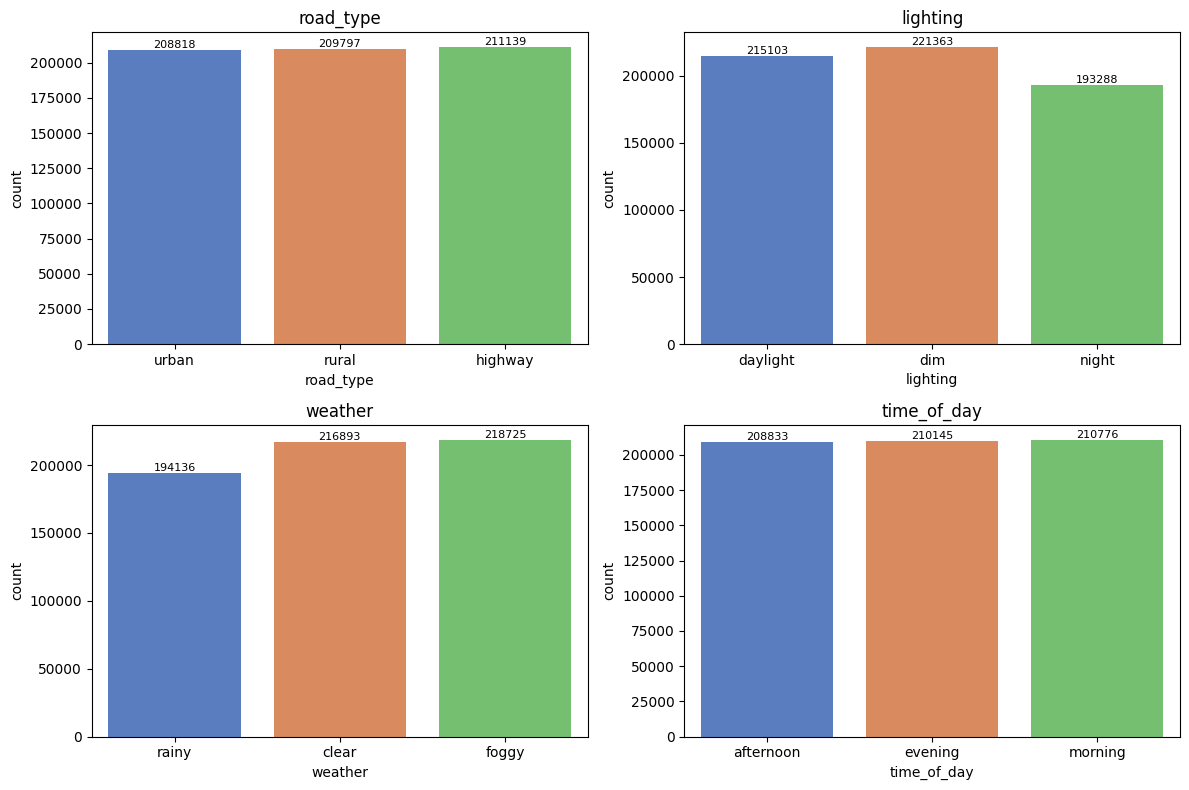

In [10]:
objCols = trainData.select_dtypes('object').columns

fig, axes = plt.subplots(nrows = 2, ncols = len(objCols) // 2, figsize = (12, 8))
axes = axes.flatten()
for col, ax in zip(objCols, axes):
    sns.countplot(data=trainData, x = col, ax = ax, palette='muted')
    ax.set_title(col)
    
    for container in ax.containers:
        ax.bar_label(container, fontsize=8)
    
plt.tight_layout()
plt.show()

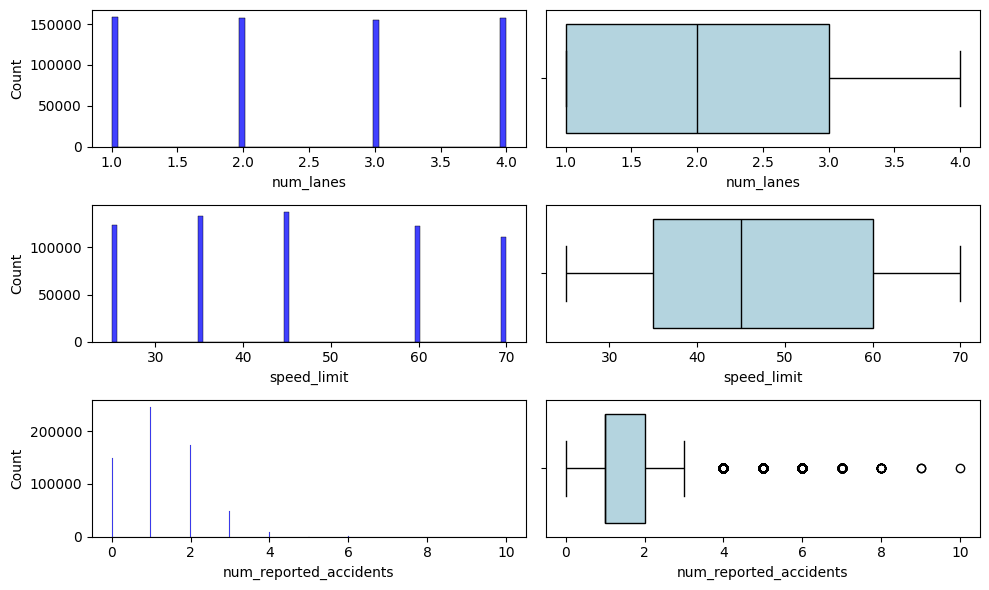

In [11]:
numCols = trainData.select_dtypes('int', 'float').columns

fig, ax = plt.subplots(nrows = len(numCols), ncols = 2, figsize = (10, 2 * len(numCols)))
for index, col in enumerate(numCols):
    sns.histplot(data = trainData, x = col, ax = ax[index, 0], color = 'blue', line_kws={'color' : 'red'})
    sns.boxplot(data=trainData, x=col, ax = ax[index, 1], color = 'lightblue', linecolor='black')

plt.tight_layout()
plt.show()

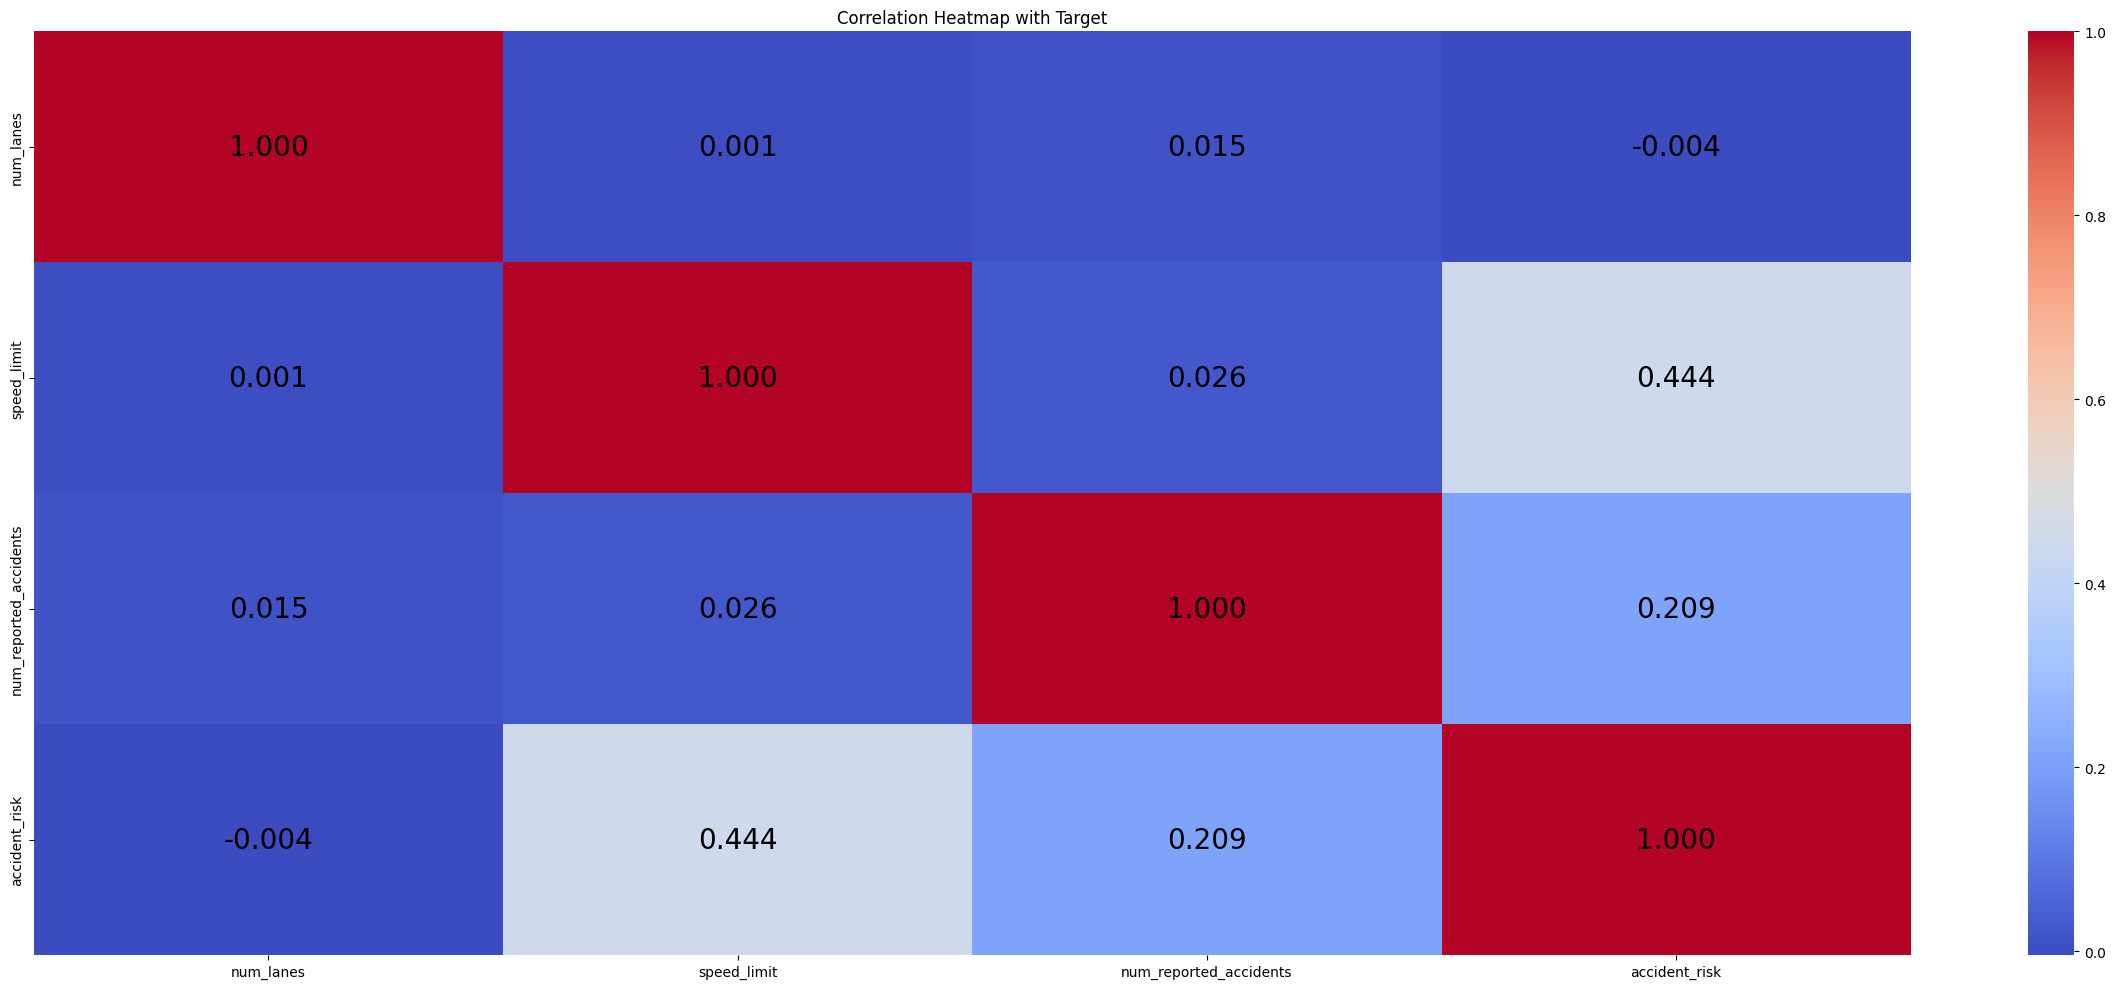

In [12]:
corr = trainData[numCols.tolist() + [TARGET]].corr()
plt.figure(figsize=(2 * len(COLUMNS), 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".3f", annot_kws={'color' : 'black', 'fontsize' : 20}, linecolor="black")
plt.title("Correlation Heatmap with Target")
plt.tight_layout()
plt.show()

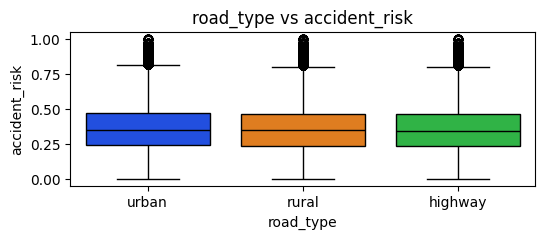

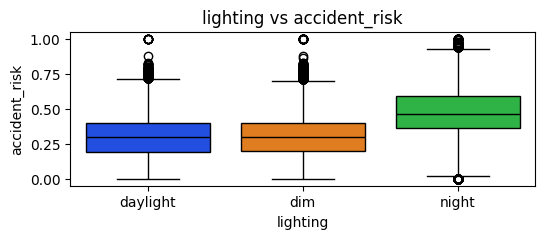

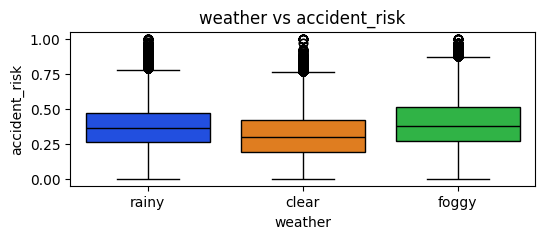

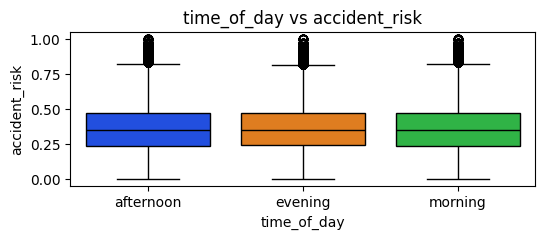

In [13]:
for col in objCols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=trainData[col], y=trainData['accident_risk'], palette='bright', linecolor='black')
    plt.title(f"{col} vs accident_risk")
    plt.show()

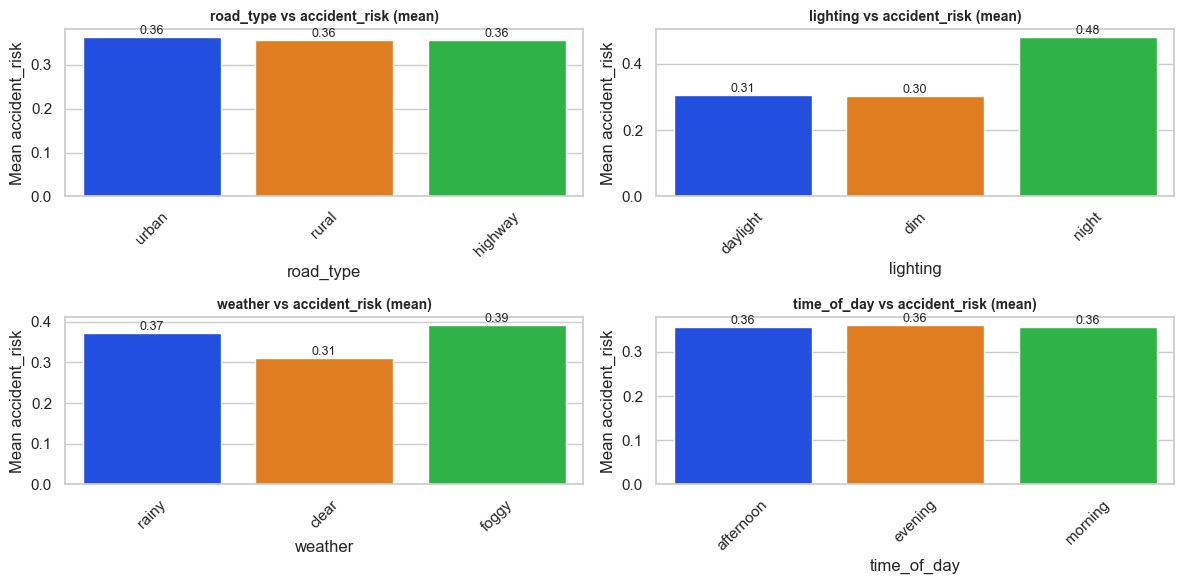

In [14]:
sns.set_theme(style="whitegrid")

# define grid size
n_cols = 2
n_rows = (len(objCols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*3))
axes = axes.flatten()  # flatten in case of single row/column

for i, col in enumerate(objCols):
    ax = axes[i]
    sns.barplot(
        data=trainData,
        x=col,
        y='accident_risk',
        estimator=np.mean,
        ci=None,
        palette='bright',
        ax=ax
    )
    ax.set_title(f"{col} vs accident_risk (mean)", fontsize=10, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel("Mean accident_risk")
    
    # Add numbers on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width()/2, height), 
                    ha='center', va='bottom', fontsize=9)

# remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 1.`Data Preprocessing & Visualization`

In [15]:
print('Train nulls:',trainData.isnull().sum().sum())
print('Test nulls:',testData.isnull().sum().sum())

Train nulls: 0
Test nulls: 0


In [16]:
print('Before:',trainData.duplicated().sum())
trainData = trainData.drop_duplicates()
print('After:',trainData.duplicated().sum())

Before: 695
After: 0


In [17]:
COLUMNS = list(trainData.columns)
COLUMNS.remove('accident_risk')

for col in trainData.select_dtypes('object').columns:
    print(f'{col} : {trainData[col].unique()}')

road_type : ['urban' 'rural' 'highway']
lighting : ['daylight' 'dim' 'night']
weather : ['rainy' 'clear' 'foggy']
time_of_day : ['afternoon' 'evening' 'morning']


In [18]:
# converting bool to int (both train and test)
boolCols = trainData.select_dtypes('bool').columns
trainData[boolCols] = trainData[boolCols].astype(int)
testData[boolCols] = testData[boolCols].astype(int)

In [19]:
# encoding string(object) features
print(objCols)
try:
    trainData = pd.get_dummies(trainData, columns=objCols,)
    testData  = pd.get_dummies(testData,  columns=objCols,)
except: 
    pass

# Convert bool → int
boolCols = trainData.select_dtypes('bool').columns
trainData[boolCols] = trainData[boolCols].astype(int)
testData[boolCols]  = testData[boolCols].astype(int)

Index(['road_type', 'lighting', 'weather', 'time_of_day'], dtype='object')


## `Dry Run (Base Model)`

In [20]:
models = {
#     'ExtraTrees' : ExtraTreesRegressor(),
#     'RandomForest' : RandomForestRegressor(),
#     'AdaBoost' : AdaBoostRegressor(),
#     'HistGradient' : HistGradientBoostingRegressor(),
#     'Gradient' : GradientBoostingRegressor()
    'XGB' : XGBRegressor(),
}

def trainModels(models: dict, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    for modelName, model in models.items():
        cv_scores = cross_val_score(
            model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=kf, n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        test_rmse = root_mean_squared_error(y_test, pred)

        print(f"{modelName}: CV RMSE = {abs(cv_scores.mean()):.4f}, Test RMSE = {test_rmse:.4f}")
        
def giveSubmission(model, testData : pd.DataFrame, X, y, fileName : str):
    model.fit(X, y)
    drySub = pd.DataFrame({'id' : testData['id'], 'accident_risk' : model.predict(testData.drop('id', axis = 1))})
    if fileName.endswith('.csv'):
        drySub.to_csv(f'../data/submissions/{fileName}', index = False)
    else:
        drySub.to_csv(f'../data/submissions/{fileName}.csv', index = False)

In [21]:
X = trainData.drop('accident_risk', axis = 1)
y = trainData['accident_risk']

# giveSubmission(XGBRegressor(), testData, X, y, 'DryRun.csv')

## 2. `Feature Engineering`

In [27]:
X = trainData.drop('accident_risk', axis=1)
y = trainData['accident_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'gpu_hist',
        'device' : 'gpu'
    }

    model = XGBRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSE:", np.sqrt(study.best_value))
print("Best params:", study.best_params)

best_model = XGBRegressor(**study.best_params)
best_model.fit(X, y)

[I 2025-10-03 00:29:01,770] A new study created in memory with name: no-name-0c60568e-3f55-4a9c-8a3a-c31bc6e85af3
Best trial: 0. Best value: 0.00357607:   1%|█▎                                                                                                                               | 1/100 [01:42<2:49:21, 102.64s/it]

[I 2025-10-03 00:30:44,414] Trial 0 finished with value: 0.0035760680732095187 and parameters: {'n_estimators': 501, 'max_depth': 12, 'learning_rate': 0.1886759762755643, 'subsample': 0.8823764813140661, 'colsample_bytree': 0.596714370981535, 'reg_alpha': 0.15826350453245128, 'reg_lambda': 3.526422012627113e-07}. Best is trial 0 with value: 0.0035760680732095187.


Best trial: 1. Best value: 0.00314344:   2%|██▌                                                                                                                               | 2/100 [02:01<1:27:21, 53.48s/it]

[I 2025-10-03 00:31:03,484] Trial 1 finished with value: 0.003143441748741695 and parameters: {'n_estimators': 862, 'max_depth': 4, 'learning_rate': 0.04566075787617071, 'subsample': 0.7549485055437842, 'colsample_bytree': 0.8671988697882084, 'reg_alpha': 0.7250625780414397, 'reg_lambda': 7.727304564178185e-08}. Best is trial 1 with value: 0.003143441748741695.


Best trial: 1. Best value: 0.00314344:   3%|███▉                                                                                                                              | 3/100 [02:31<1:09:14, 42.83s/it]

[I 2025-10-03 00:31:33,627] Trial 2 finished with value: 0.0032555145371514225 and parameters: {'n_estimators': 582, 'max_depth': 8, 'learning_rate': 0.26747039627443203, 'subsample': 0.687235359456313, 'colsample_bytree': 0.9622347746648392, 'reg_alpha': 0.9464252600131033, 'reg_lambda': 1.3560629130842527e-06}. Best is trial 1 with value: 0.003143441748741695.


Best trial: 1. Best value: 0.00314344:   4%|█████▏                                                                                                                            | 4/100 [03:10<1:06:01, 41.27s/it]

[I 2025-10-03 00:32:12,508] Trial 3 finished with value: 0.004318079879194254 and parameters: {'n_estimators': 115, 'max_depth': 12, 'learning_rate': 0.016449563277488193, 'subsample': 0.9361604837188038, 'colsample_bytree': 0.7809304711507545, 'reg_alpha': 2.3337509565063413e-07, 'reg_lambda': 3.8513694817142985e-06}. Best is trial 1 with value: 0.003143441748741695.


Best trial: 1. Best value: 0.00314344:   5%|██████▌                                                                                                                           | 5/100 [06:02<2:19:48, 88.30s/it]

[I 2025-10-03 00:35:04,215] Trial 4 finished with value: 0.0035319353695237843 and parameters: {'n_estimators': 550, 'max_depth': 12, 'learning_rate': 0.055780351176336604, 'subsample': 0.9491403079137369, 'colsample_bytree': 0.8578574550897409, 'reg_alpha': 1.9663804010718824e-07, 'reg_lambda': 1.5012069596798167e-08}. Best is trial 1 with value: 0.003143441748741695.


Best trial: 1. Best value: 0.00314344:   6%|███████▋                                                                                                                         | 6/100 [08:18<2:43:32, 104.39s/it]

[I 2025-10-03 00:37:19,823] Trial 5 finished with value: 0.003487681620473008 and parameters: {'n_estimators': 433, 'max_depth': 12, 'learning_rate': 0.08970515975800353, 'subsample': 0.723631526711165, 'colsample_bytree': 0.5793145857760359, 'reg_alpha': 1.6492462020766745e-08, 'reg_lambda': 6.753507411895846e-05}. Best is trial 1 with value: 0.003143441748741695.


Best trial: 1. Best value: 0.00314344:   7%|█████████                                                                                                                         | 7/100 [08:25<1:52:46, 72.76s/it]

[I 2025-10-03 00:37:27,463] Trial 6 finished with value: 0.0038631571528139905 and parameters: {'n_estimators': 271, 'max_depth': 3, 'learning_rate': 0.014132195345172216, 'subsample': 0.8107346125747269, 'colsample_bytree': 0.5077043721831322, 'reg_alpha': 0.3154968722846925, 'reg_lambda': 1.332353740684486e-05}. Best is trial 1 with value: 0.003143441748741695.


Best trial: 1. Best value: 0.00314344:   8%|██████████▍                                                                                                                       | 8/100 [08:37<1:21:35, 53.21s/it]

[I 2025-10-03 00:37:38,805] Trial 7 finished with value: 0.0031474381547654693 and parameters: {'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.1690460605611118, 'subsample': 0.7216281837398462, 'colsample_bytree': 0.6678270957392098, 'reg_alpha': 0.00046616499919312497, 'reg_lambda': 0.45079332126425514}. Best is trial 1 with value: 0.003143441748741695.


Best trial: 8. Best value: 0.00313613:   9%|███████████▋                                                                                                                      | 9/100 [08:50<1:01:46, 40.73s/it]

[I 2025-10-03 00:37:52,112] Trial 8 finished with value: 0.0031361292913404523 and parameters: {'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.03729605272380582, 'subsample': 0.957518218942939, 'colsample_bytree': 0.6288001081043333, 'reg_alpha': 2.3439517403951094e-07, 'reg_lambda': 4.791443139122583e-07}. Best is trial 8 with value: 0.0031361292913404523.


Best trial: 8. Best value: 0.00313613:  10%|████████████▉                                                                                                                    | 10/100 [09:53<1:11:17, 47.52s/it]

[I 2025-10-03 00:38:54,842] Trial 9 finished with value: 0.003230762429571947 and parameters: {'n_estimators': 503, 'max_depth': 12, 'learning_rate': 0.15818708429659462, 'subsample': 0.5470167973397231, 'colsample_bytree': 0.6112260287096531, 'reg_alpha': 1.047759664018697, 'reg_lambda': 0.26107030864820047}. Best is trial 8 with value: 0.0031361292913404523.


Best trial: 10. Best value: 0.00313513:  11%|██████████████                                                                                                                  | 11/100 [10:28<1:04:52, 43.74s/it]

[I 2025-10-03 00:39:29,989] Trial 10 finished with value: 0.0031351290811848682 and parameters: {'n_estimators': 780, 'max_depth': 7, 'learning_rate': 0.02717954070204468, 'subsample': 0.9987029611369233, 'colsample_bytree': 0.7123348552090042, 'reg_alpha': 2.7604604357041935e-05, 'reg_lambda': 0.002996266222046955}. Best is trial 10 with value: 0.0031351290811848682.


Best trial: 10. Best value: 0.00313513:  12%|███████████████▎                                                                                                                | 12/100 [11:08<1:02:45, 42.79s/it]

[I 2025-10-03 00:40:10,604] Trial 11 finished with value: 0.0031355978633169886 and parameters: {'n_estimators': 819, 'max_depth': 7, 'learning_rate': 0.027324158257741385, 'subsample': 0.994872756107574, 'colsample_bytree': 0.7185753277474078, 'reg_alpha': 3.5363049066184e-05, 'reg_lambda': 0.003541009663092722}. Best is trial 10 with value: 0.0031351290811848682.


Best trial: 10. Best value: 0.00313513:  13%|████████████████▋                                                                                                               | 13/100 [12:03<1:07:02, 46.24s/it]

[I 2025-10-03 00:41:04,777] Trial 12 finished with value: 0.003140782051217384 and parameters: {'n_estimators': 870, 'max_depth': 8, 'learning_rate': 0.02293960067130653, 'subsample': 0.9979287708645721, 'colsample_bytree': 0.7271304750680391, 'reg_alpha': 7.504353727119198e-05, 'reg_lambda': 0.004370676576381376}. Best is trial 10 with value: 0.0031351290811848682.


Best trial: 13. Best value: 0.00313447:  14%|█████████████████▉                                                                                                              | 14/100 [13:13<1:16:35, 53.43s/it]

[I 2025-10-03 00:42:14,843] Trial 13 finished with value: 0.003134474140842438 and parameters: {'n_estimators': 744, 'max_depth': 9, 'learning_rate': 0.010136062345614242, 'subsample': 0.8521751625724464, 'colsample_bytree': 0.7458362701400175, 'reg_alpha': 8.437795670284402e-05, 'reg_lambda': 0.002241309264162125}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 13. Best value: 0.00313447:  15%|███████████████████▏                                                                                                            | 15/100 [14:53<1:35:36, 67.49s/it]

[I 2025-10-03 00:43:54,906] Trial 14 finished with value: 0.0031491316243027123 and parameters: {'n_estimators': 715, 'max_depth': 10, 'learning_rate': 0.010691803768994805, 'subsample': 0.8556398667647938, 'colsample_bytree': 0.7925108083316662, 'reg_alpha': 0.0031603916545647906, 'reg_lambda': 0.006442543533655077}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 13. Best value: 0.00313447:  16%|████████████████████▍                                                                                                           | 16/100 [16:20<1:42:42, 73.36s/it]

[I 2025-10-03 00:45:21,910] Trial 15 finished with value: 0.003139691702837042 and parameters: {'n_estimators': 961, 'max_depth': 9, 'learning_rate': 0.010348172511997024, 'subsample': 0.6334336469120663, 'colsample_bytree': 0.8444751693220149, 'reg_alpha': 7.227206248575271e-06, 'reg_lambda': 0.0004256466201695222}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 13. Best value: 0.00313447:  17%|█████████████████████▊                                                                                                          | 17/100 [17:48<1:47:53, 77.99s/it]

[I 2025-10-03 00:46:50,657] Trial 16 finished with value: 0.0031632771264500986 and parameters: {'n_estimators': 714, 'max_depth': 10, 'learning_rate': 0.023570642665438995, 'subsample': 0.8754842920138293, 'colsample_bytree': 0.6868816890116104, 'reg_alpha': 0.0048159050750059135, 'reg_lambda': 5.974591926625581}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 13. Best value: 0.00313447:  18%|███████████████████████                                                                                                         | 18/100 [18:14<1:25:13, 62.36s/it]

[I 2025-10-03 00:47:16,640] Trial 17 finished with value: 0.0031451169147187112 and parameters: {'n_estimators': 660, 'max_depth': 6, 'learning_rate': 0.07395148536811157, 'subsample': 0.8117581833251464, 'colsample_bytree': 0.9660695490727964, 'reg_alpha': 4.5077237932445616e-06, 'reg_lambda': 0.023873739057157808}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 13. Best value: 0.00313447:  19%|████████████████████████▎                                                                                                       | 19/100 [20:21<1:50:16, 81.69s/it]

[I 2025-10-03 00:49:23,354] Trial 18 finished with value: 0.0031758735757210165 and parameters: {'n_estimators': 966, 'max_depth': 10, 'learning_rate': 0.016169324365419853, 'subsample': 0.9153531082709605, 'colsample_bytree': 0.7857232207690136, 'reg_alpha': 0.01449610347327618, 'reg_lambda': 0.08845262885490035}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 13. Best value: 0.00313447:  20%|█████████████████████████▌                                                                                                      | 20/100 [21:00<1:31:36, 68.71s/it]

[I 2025-10-03 00:50:01,804] Trial 19 finished with value: 0.0031422533355662933 and parameters: {'n_estimators': 783, 'max_depth': 7, 'learning_rate': 0.03574773374982979, 'subsample': 0.8120335381499993, 'colsample_bytree': 0.9062226125660184, 'reg_alpha': 0.0002520773558699988, 'reg_lambda': 0.0007525127366328004}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 13. Best value: 0.00313447:  21%|██████████████████████████▉                                                                                                     | 21/100 [22:09<1:30:38, 68.84s/it]

[I 2025-10-03 00:51:10,945] Trial 20 finished with value: 0.0032874389267457844 and parameters: {'n_estimators': 641, 'max_depth': 9, 'learning_rate': 0.09321188100221096, 'subsample': 0.5249530851800599, 'colsample_bytree': 0.6764331357698206, 'reg_alpha': 4.7367019671608955e-06, 'reg_lambda': 9.757612249989604e-05}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 13. Best value: 0.00313447:  22%|████████████████████████████▏                                                                                                   | 22/100 [22:48<1:17:56, 59.96s/it]

[I 2025-10-03 00:51:50,198] Trial 21 finished with value: 0.0031353523006822396 and parameters: {'n_estimators': 826, 'max_depth': 7, 'learning_rate': 0.02699140891879686, 'subsample': 0.9983103380821541, 'colsample_bytree': 0.7369026875126995, 'reg_alpha': 4.608241306119073e-05, 'reg_lambda': 0.0023101581405659166}. Best is trial 13 with value: 0.003134474140842438.


Best trial: 22. Best value: 0.0031329:  23%|█████████████████████████████▋                                                                                                   | 23/100 [23:19<1:05:41, 51.19s/it]

[I 2025-10-03 00:52:20,929] Trial 22 finished with value: 0.0031328996871165275 and parameters: {'n_estimators': 764, 'max_depth': 6, 'learning_rate': 0.019724624910257726, 'subsample': 0.9941847418623285, 'colsample_bytree': 0.7508051705059706, 'reg_alpha': 0.0008031714650406539, 'reg_lambda': 0.0009873323372121814}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  24%|███████████████████████████████▍                                                                                                   | 24/100 [23:44<54:51, 43.30s/it]

[I 2025-10-03 00:52:45,837] Trial 23 finished with value: 0.00313733606620158 and parameters: {'n_estimators': 728, 'max_depth': 5, 'learning_rate': 0.018948184302986268, 'subsample': 0.9063414239226047, 'colsample_bytree': 0.8118864163175226, 'reg_alpha': 0.000671683278635839, 'reg_lambda': 6.486144862976306e-05}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  25%|████████████████████████████████▊                                                                                                  | 25/100 [24:18<50:40, 40.54s/it]

[I 2025-10-03 00:53:19,918] Trial 24 finished with value: 0.0031414303200945843 and parameters: {'n_estimators': 899, 'max_depth': 6, 'learning_rate': 0.013162317152824492, 'subsample': 0.8363926708296663, 'colsample_bytree': 0.7564190031124779, 'reg_alpha': 9.455469381594646, 'reg_lambda': 0.02205780030496714}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  26%|█████████████████████████████████▌                                                                                               | 26/100 [25:28<1:00:59, 49.45s/it]

[I 2025-10-03 00:54:30,157] Trial 25 finished with value: 0.0031488490847006332 and parameters: {'n_estimators': 784, 'max_depth': 9, 'learning_rate': 0.02107790522983183, 'subsample': 0.9530354840088289, 'colsample_bytree': 0.6484663686949544, 'reg_alpha': 0.002226214730236034, 'reg_lambda': 0.0006297093619353956}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  27%|███████████████████████████████████▎                                                                                               | 27/100 [25:51<50:37, 41.62s/it]

[I 2025-10-03 00:54:53,498] Trial 26 finished with value: 0.003142347483766618 and parameters: {'n_estimators': 649, 'max_depth': 5, 'learning_rate': 0.01334758532722295, 'subsample': 0.7771447563951834, 'colsample_bytree': 0.7059829054508223, 'reg_alpha': 0.04651646281648142, 'reg_lambda': 2.530907061396031}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  28%|████████████████████████████████████▋                                                                                              | 28/100 [26:49<55:35, 46.32s/it]

[I 2025-10-03 00:55:50,812] Trial 27 finished with value: 0.003150553574380723 and parameters: {'n_estimators': 745, 'max_depth': 8, 'learning_rate': 0.035285756505609105, 'subsample': 0.903227477397374, 'colsample_bytree': 0.761888459256381, 'reg_alpha': 1.1902398287274979e-06, 'reg_lambda': 1.3183920428274023e-05}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  29%|█████████████████████████████████████▉                                                                                             | 29/100 [27:17<48:24, 40.91s/it]

[I 2025-10-03 00:56:19,088] Trial 28 finished with value: 0.003146271776304232 and parameters: {'n_estimators': 923, 'max_depth': 4, 'learning_rate': 0.029802982952336573, 'subsample': 0.6105366835032537, 'colsample_bytree': 0.8290109814818468, 'reg_alpha': 0.00011147647658372247, 'reg_lambda': 0.027500915257786803}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  30%|██████████████████████████████████████▋                                                                                          | 30/100 [29:28<1:19:11, 67.88s/it]

[I 2025-10-03 00:58:29,910] Trial 29 finished with value: 0.0031712508038394113 and parameters: {'n_estimators': 600, 'max_depth': 11, 'learning_rate': 0.010264746572712298, 'subsample': 0.880135204363174, 'colsample_bytree': 0.5628991425257602, 'reg_alpha': 1.662389436210407e-05, 'reg_lambda': 0.0002044411716008457}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  31%|███████████████████████████████████████▉                                                                                         | 31/100 [29:46<1:01:01, 53.06s/it]

[I 2025-10-03 00:58:48,393] Trial 30 finished with value: 0.003133765139131081 and parameters: {'n_estimators': 447, 'max_depth': 6, 'learning_rate': 0.0176438273526905, 'subsample': 0.9686027928513232, 'colsample_bytree': 0.9042843425465641, 'reg_alpha': 0.0008410713253689229, 'reg_lambda': 0.001156408387599577}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  32%|█████████████████████████████████████████▉                                                                                         | 32/100 [30:04<48:16, 42.60s/it]

[I 2025-10-03 00:59:06,560] Trial 31 finished with value: 0.0031341736599788906 and parameters: {'n_estimators': 429, 'max_depth': 6, 'learning_rate': 0.018086964927745496, 'subsample': 0.9727489239538065, 'colsample_bytree': 0.9279896899385048, 'reg_alpha': 0.001371613265400796, 'reg_lambda': 0.0012570792550291518}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  33%|███████████████████████████████████████████▏                                                                                       | 33/100 [30:20<38:41, 34.65s/it]

[I 2025-10-03 00:59:22,681] Trial 32 finished with value: 0.0031354761930939257 and parameters: {'n_estimators': 392, 'max_depth': 6, 'learning_rate': 0.01739371134233919, 'subsample': 0.9543895059415746, 'colsample_bytree': 0.9261708832471969, 'reg_alpha': 0.0012717605240716067, 'reg_lambda': 0.001053796918243619}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  34%|████████████████████████████████████████████▌                                                                                      | 34/100 [30:31<30:16, 27.52s/it]

[I 2025-10-03 00:59:33,557] Trial 33 finished with value: 0.0031825758953204566 and parameters: {'n_estimators': 421, 'max_depth': 4, 'learning_rate': 0.013272443410448451, 'subsample': 0.9732509410620539, 'colsample_bytree': 0.9120174919953381, 'reg_alpha': 0.016488413955845084, 'reg_lambda': 2.2199765872698196e-05}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 22. Best value: 0.0031329:  35%|█████████████████████████████████████████████▊                                                                                     | 35/100 [30:48<26:13, 24.20s/it]

[I 2025-10-03 00:59:50,019] Trial 34 finished with value: 0.0031363951814579218 and parameters: {'n_estimators': 492, 'max_depth': 5, 'learning_rate': 0.04961610870674339, 'subsample': 0.9192925896173411, 'colsample_bytree': 0.9395613307011605, 'reg_alpha': 0.00018262820431218552, 'reg_lambda': 0.008687356775374737}. Best is trial 22 with value: 0.0031328996871165275.


Best trial: 35. Best value: 0.00312919:  36%|██████████████████████████████████████████████▊                                                                                   | 36/100 [31:12<25:46, 24.17s/it]

[I 2025-10-03 01:00:14,102] Trial 35 finished with value: 0.0031291943370235003 and parameters: {'n_estimators': 352, 'max_depth': 8, 'learning_rate': 0.019591592396180114, 'subsample': 0.8710651099871863, 'colsample_bytree': 0.9951506608219521, 'reg_alpha': 0.011229532637722523, 'reg_lambda': 0.00022044978089728225}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 35. Best value: 0.00312919:  37%|████████████████████████████████████████████████                                                                                  | 37/100 [31:28<22:43, 21.65s/it]

[I 2025-10-03 01:00:29,867] Trial 36 finished with value: 0.003134577283780724 and parameters: {'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.019390260372279138, 'subsample': 0.9334609664043223, 'colsample_bytree': 0.9900741299789404, 'reg_alpha': 0.010058177078128058, 'reg_lambda': 5.435356445804433e-06}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 35. Best value: 0.00312919:  38%|█████████████████████████████████████████████████▍                                                                                | 38/100 [31:41<19:40, 19.03s/it]

[I 2025-10-03 01:00:42,809] Trial 37 finished with value: 0.003130675250631021 and parameters: {'n_estimators': 182, 'max_depth': 8, 'learning_rate': 0.04247035802225551, 'subsample': 0.9693969536069077, 'colsample_bytree': 0.9819513341212294, 'reg_alpha': 0.06690834956527163, 'reg_lambda': 0.00017294973361792757}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 35. Best value: 0.00312919:  39%|██████████████████████████████████████████████████▋                                                                               | 39/100 [31:53<17:11, 16.92s/it]

[I 2025-10-03 01:00:54,777] Trial 38 finished with value: 0.003130117493209083 and parameters: {'n_estimators': 159, 'max_depth': 8, 'learning_rate': 0.04275115223070384, 'subsample': 0.9291161987063717, 'colsample_bytree': 0.8827174035615282, 'reg_alpha': 0.09413578775554705, 'reg_lambda': 0.0002641156411562091}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 35. Best value: 0.00312919:  40%|████████████████████████████████████████████████████                                                                              | 40/100 [32:02<14:49, 14.82s/it]

[I 2025-10-03 01:01:04,719] Trial 39 finished with value: 0.0031317409382270816 and parameters: {'n_estimators': 130, 'max_depth': 8, 'learning_rate': 0.0614566620441658, 'subsample': 0.9354184931016518, 'colsample_bytree': 0.8793905512494705, 'reg_alpha': 0.07586603604351028, 'reg_lambda': 5.116043624796466e-05}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 35. Best value: 0.00312919:  41%|█████████████████████████████████████████████████████▎                                                                            | 41/100 [32:11<12:49, 13.04s/it]

[I 2025-10-03 01:01:13,585] Trial 40 finished with value: 0.003130755527815796 and parameters: {'n_estimators': 113, 'max_depth': 8, 'learning_rate': 0.0651017030335326, 'subsample': 0.8916477999434603, 'colsample_bytree': 0.8761709046688392, 'reg_alpha': 0.11012806500583407, 'reg_lambda': 7.190974439765459e-07}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 35. Best value: 0.00312919:  42%|██████████████████████████████████████████████████████▌                                                                           | 42/100 [32:20<11:13, 11.62s/it]

[I 2025-10-03 01:01:21,889] Trial 41 finished with value: 0.0031305468323405495 and parameters: {'n_estimators': 103, 'max_depth': 8, 'learning_rate': 0.058450331936907, 'subsample': 0.8933133007675169, 'colsample_bytree': 0.8848635468677741, 'reg_alpha': 0.1012978931217933, 'reg_lambda': 5.6844013188169676e-08}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 35. Best value: 0.00312919:  43%|███████████████████████████████████████████████████████▉                                                                          | 43/100 [32:32<11:14, 11.83s/it]

[I 2025-10-03 01:01:34,215] Trial 42 finished with value: 0.003145559008647017 and parameters: {'n_estimators': 186, 'max_depth': 8, 'learning_rate': 0.11512246646636852, 'subsample': 0.8907742125775695, 'colsample_bytree': 0.9979290940977364, 'reg_alpha': 0.29916022058636843, 'reg_lambda': 5.951663042551142e-08}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 35. Best value: 0.00312919:  44%|█████████████████████████████████████████████████████████▏                                                                        | 44/100 [32:44<11:14, 12.04s/it]

[I 2025-10-03 01:01:46,733] Trial 43 finished with value: 0.0031304778904153426 and parameters: {'n_estimators': 203, 'max_depth': 8, 'learning_rate': 0.04361353798309217, 'subsample': 0.7867345461205962, 'colsample_bytree': 0.9627981777369854, 'reg_alpha': 2.999326876518207, 'reg_lambda': 6.248644727477825e-07}. Best is trial 35 with value: 0.0031291943370235003.


Best trial: 44. Best value: 0.00312907:  45%|██████████████████████████████████████████████████████████▌                                                                       | 45/100 [33:01<12:08, 13.24s/it]

[I 2025-10-03 01:02:02,798] Trial 44 finished with value: 0.0031290716145370946 and parameters: {'n_estimators': 214, 'max_depth': 9, 'learning_rate': 0.04056926814256155, 'subsample': 0.7801390792424823, 'colsample_bytree': 0.961863540584986, 'reg_alpha': 2.5344177396678007, 'reg_lambda': 1.6090790012396429e-07}. Best is trial 44 with value: 0.0031290716145370946.


Best trial: 44. Best value: 0.00312907:  46%|███████████████████████████████████████████████████████████▊                                                                      | 46/100 [33:18<13:09, 14.61s/it]

[I 2025-10-03 01:02:20,603] Trial 45 finished with value: 0.003129278024922538 and parameters: {'n_estimators': 240, 'max_depth': 9, 'learning_rate': 0.052322982754082877, 'subsample': 0.7690514321849852, 'colsample_bytree': 0.9501300013136201, 'reg_alpha': 2.5360432104565627, 'reg_lambda': 1.4151225104385083e-07}. Best is trial 44 with value: 0.0031290716145370946.


Best trial: 44. Best value: 0.00312907:  47%|█████████████████████████████████████████████████████████████                                                                     | 47/100 [33:35<13:25, 15.20s/it]

[I 2025-10-03 01:02:37,173] Trial 46 finished with value: 0.0031296104039166576 and parameters: {'n_estimators': 234, 'max_depth': 9, 'learning_rate': 0.04549412684010426, 'subsample': 0.7317524056845406, 'colsample_bytree': 0.9542198278703603, 'reg_alpha': 2.8124345418933707, 'reg_lambda': 2.1063894952923856e-07}. Best is trial 44 with value: 0.0031290716145370946.


Best trial: 44. Best value: 0.00312907:  48%|██████████████████████████████████████████████████████████████▍                                                                   | 48/100 [33:55<14:25, 16.64s/it]

[I 2025-10-03 01:02:57,175] Trial 47 finished with value: 0.003137635033266354 and parameters: {'n_estimators': 234, 'max_depth': 9, 'learning_rate': 0.08036348007178419, 'subsample': 0.7307640021759344, 'colsample_bytree': 0.9445334118042862, 'reg_alpha': 1.2833729658842317, 'reg_lambda': 1.0131043511463513e-08}. Best is trial 44 with value: 0.0031290716145370946.


Best trial: 44. Best value: 0.00312907:  49%|███████████████████████████████████████████████████████████████▋                                                                  | 49/100 [34:17<15:25, 18.14s/it]

[I 2025-10-03 01:03:18,824] Trial 48 finished with value: 0.0031339865718986123 and parameters: {'n_estimators': 326, 'max_depth': 11, 'learning_rate': 0.049511818428447346, 'subsample': 0.6913948719175982, 'colsample_bytree': 0.956031596641225, 'reg_alpha': 6.255056734759092, 'reg_lambda': 2.147442514137135e-07}. Best is trial 44 with value: 0.0031290716145370946.


Best trial: 44. Best value: 0.00312907:  50%|█████████████████████████████████████████████████████████████████                                                                 | 50/100 [34:47<18:08, 21.77s/it]

[I 2025-10-03 01:03:49,044] Trial 49 finished with value: 0.003323036349898266 and parameters: {'n_estimators': 245, 'max_depth': 10, 'learning_rate': 0.2577638351250807, 'subsample': 0.7539206531600411, 'colsample_bytree': 0.9829869932842717, 'reg_alpha': 0.5009740297789985, 'reg_lambda': 2.626290193782998e-06}. Best is trial 44 with value: 0.0031290716145370946.


Best trial: 44. Best value: 0.00312907:  51%|██████████████████████████████████████████████████████████████████▎                                                               | 51/100 [34:58<15:11, 18.59s/it]

[I 2025-10-03 01:04:00,239] Trial 50 finished with value: 0.0031397586408505205 and parameters: {'n_estimators': 158, 'max_depth': 9, 'learning_rate': 0.030895677706558187, 'subsample': 0.6838972019070912, 'colsample_bytree': 0.8541684698983233, 'reg_alpha': 2.2616211519890377, 'reg_lambda': 1.9647652306328669e-07}. Best is trial 44 with value: 0.0031290716145370946.


Best trial: 51. Best value: 0.00312862:  52%|███████████████████████████████████████████████████████████████████▌                                                              | 52/100 [35:14<14:10, 17.72s/it]

[I 2025-10-03 01:04:15,931] Trial 51 finished with value: 0.003128617026591558 and parameters: {'n_estimators': 224, 'max_depth': 9, 'learning_rate': 0.04175782941239012, 'subsample': 0.7798061415565349, 'colsample_bytree': 0.9659692179000215, 'reg_alpha': 2.4527327335867932, 'reg_lambda': 1.4278010697966022e-06}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  53%|████████████████████████████████████████████████████████████████████▉                                                             | 53/100 [35:31<13:53, 17.74s/it]

[I 2025-10-03 01:04:33,696] Trial 52 finished with value: 0.003129485605369621 and parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.04222322920893199, 'subsample': 0.7675785998469125, 'colsample_bytree': 0.9731054471192986, 'reg_alpha': 3.1397422362359393, 'reg_lambda': 2.2449996320753637e-08}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  54%|██████████████████████████████████████████████████████████████████████▏                                                           | 54/100 [35:52<14:11, 18.51s/it]

[I 2025-10-03 01:04:54,003] Trial 53 finished with value: 0.0031302313205916676 and parameters: {'n_estimators': 273, 'max_depth': 10, 'learning_rate': 0.05339329747811401, 'subsample': 0.7711486502176708, 'colsample_bytree': 0.9709158741850312, 'reg_alpha': 3.2754479783135793, 'reg_lambda': 3.919645301981585e-08}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  55%|███████████████████████████████████████████████████████████████████████▌                                                          | 55/100 [36:20<16:01, 21.37s/it]

[I 2025-10-03 01:05:22,044] Trial 54 finished with value: 0.0031402102727387743 and parameters: {'n_estimators': 340, 'max_depth': 9, 'learning_rate': 0.03667830109356442, 'subsample': 0.7034617135808847, 'colsample_bytree': 0.9489298576984782, 'reg_alpha': 0.2700055269929897, 'reg_lambda': 1.4119077797745518e-07}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  56%|████████████████████████████████████████████████████████████████████████▊                                                         | 56/100 [36:51<17:49, 24.31s/it]

[I 2025-10-03 01:05:53,223] Trial 55 finished with value: 0.003154640994777168 and parameters: {'n_estimators': 229, 'max_depth': 11, 'learning_rate': 0.07361289305621234, 'subsample': 0.736263300557988, 'colsample_bytree': 0.9982326242543534, 'reg_alpha': 0.9239382661616485, 'reg_lambda': 2.424826131928478e-08}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  57%|██████████████████████████████████████████████████████████████████████████                                                        | 57/100 [37:20<18:30, 25.82s/it]

[I 2025-10-03 01:06:22,556] Trial 56 finished with value: 0.0031557349467593795 and parameters: {'n_estimators': 299, 'max_depth': 10, 'learning_rate': 0.11186511736985148, 'subsample': 0.7991850656048103, 'colsample_bytree': 0.9240373323566753, 'reg_alpha': 1.6257581474697496, 'reg_lambda': 2.299157140435056e-06}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 58/100 [37:43<17:20, 24.79s/it]

[I 2025-10-03 01:06:44,933] Trial 57 finished with value: 0.003131648574855371 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.032221079134885915, 'subsample': 0.8334771672935822, 'colsample_bytree': 0.9685274192276355, 'reg_alpha': 5.347050484291909, 'reg_lambda': 1.1746514348013512e-06}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  59%|████████████████████████████████████████████████████████████████████████████▋                                                     | 59/100 [38:05<16:20, 23.90s/it]

[I 2025-10-03 01:07:06,782] Trial 58 finished with value: 0.0031319188776117992 and parameters: {'n_estimators': 255, 'max_depth': 9, 'learning_rate': 0.03975026820252479, 'subsample': 0.6443540641921779, 'colsample_bytree': 0.8990595292536072, 'reg_alpha': 0.580609578404307, 'reg_lambda': 1.1149164566468933e-07}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  60%|██████████████████████████████████████████████████████████████████████████████                                                    | 60/100 [38:21<14:24, 21.61s/it]

[I 2025-10-03 01:07:23,027] Trial 59 finished with value: 0.003143710692068516 and parameters: {'n_estimators': 282, 'max_depth': 10, 'learning_rate': 0.024251214151469594, 'subsample': 0.7655152290799345, 'colsample_bytree': 0.9360943263147351, 'reg_alpha': 9.724614449916919, 'reg_lambda': 3.340369538466352e-07}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  61%|███████████████████████████████████████████████████████████████████████████████▎                                                  | 61/100 [38:40<13:36, 20.94s/it]

[I 2025-10-03 01:07:42,423] Trial 60 finished with value: 0.0031401027943174795 and parameters: {'n_estimators': 214, 'max_depth': 9, 'learning_rate': 0.051528594699883044, 'subsample': 0.7473926267163329, 'colsample_bytree': 0.9745295168676016, 'reg_alpha': 0.2385887220910053, 'reg_lambda': 2.7943702813674596e-08}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 62/100 [38:49<10:55, 17.24s/it]

[I 2025-10-03 01:07:51,024] Trial 61 finished with value: 0.0031301408054103695 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.04620952089279317, 'subsample': 0.713955186046017, 'colsample_bytree': 0.9538076368109432, 'reg_alpha': 0.8159853190432204, 'reg_lambda': 1.618618598953697e-08}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  63%|█████████████████████████████████████████████████████████████████████████████████▉                                                | 63/100 [38:58<09:09, 14.85s/it]

[I 2025-10-03 01:08:00,303] Trial 62 finished with value: 0.003131254126783949 and parameters: {'n_estimators': 163, 'max_depth': 7, 'learning_rate': 0.06752601611202316, 'subsample': 0.8520963022912718, 'colsample_bytree': 0.9995196501592085, 'reg_alpha': 0.03596066161684056, 'reg_lambda': 8.190798404059849e-08}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 64/100 [39:19<09:59, 16.65s/it]

[I 2025-10-03 01:08:21,163] Trial 63 finished with value: 0.0031291730582848364 and parameters: {'n_estimators': 309, 'max_depth': 9, 'learning_rate': 0.038951137157156965, 'subsample': 0.7980463533036717, 'colsample_bytree': 0.9171165530364104, 'reg_alpha': 2.9980825110238922, 'reg_lambda': 3.6661589074753924e-07}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  65%|████████████████████████████████████████████████████████████████████████████████████▌                                             | 65/100 [39:40<10:29, 18.00s/it]

[I 2025-10-03 01:08:42,289] Trial 64 finished with value: 0.0031305913194920204 and parameters: {'n_estimators': 317, 'max_depth': 9, 'learning_rate': 0.03481091824573955, 'subsample': 0.7906838751180262, 'colsample_bytree': 0.9100159495841212, 'reg_alpha': 4.259015049707003, 'reg_lambda': 4.1573538355221585e-07}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 51. Best value: 0.00312862:  66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 66/100 [40:13<12:49, 22.62s/it]

[I 2025-10-03 01:09:15,711] Trial 65 finished with value: 0.0031288364501707343 and parameters: {'n_estimators': 359, 'max_depth': 10, 'learning_rate': 0.027225837620777016, 'subsample': 0.8245866984183741, 'colsample_bytree': 0.9779061730024398, 'reg_alpha': 1.5946231781985125, 'reg_lambda': 1.2978215737803123e-06}. Best is trial 51 with value: 0.003128617026591558.


Best trial: 66. Best value: 0.0031286:  67%|███████████████████████████████████████████████████████████████████████████████████████▊                                           | 67/100 [40:48<14:21, 26.10s/it]

[I 2025-10-03 01:09:49,909] Trial 66 finished with value: 0.0031286034572895775 and parameters: {'n_estimators': 364, 'max_depth': 10, 'learning_rate': 0.023761588758821554, 'subsample': 0.8231509671620449, 'colsample_bytree': 0.9773475584036441, 'reg_alpha': 1.4257613181343833, 'reg_lambda': 7.531220774356107e-06}. Best is trial 66 with value: 0.0031286034572895775.


Best trial: 67. Best value: 0.00312845:  68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 68/100 [41:28<16:14, 30.45s/it]

[I 2025-10-03 01:10:30,505] Trial 67 finished with value: 0.0031284486679146184 and parameters: {'n_estimators': 370, 'max_depth': 11, 'learning_rate': 0.022366261165197368, 'subsample': 0.8243680761681702, 'colsample_bytree': 0.9317411962160409, 'reg_alpha': 1.445760419797469, 'reg_lambda': 7.876349025967001e-06}. Best is trial 67 with value: 0.0031284486679146184.


Best trial: 67. Best value: 0.00312845:  69%|█████████████████████████████████████████████████████████████████████████████████████████▋                                        | 69/100 [42:41<22:14, 43.05s/it]

[I 2025-10-03 01:11:42,951] Trial 68 finished with value: 0.0031395153606045114 and parameters: {'n_estimators': 476, 'max_depth': 11, 'learning_rate': 0.015347131205644604, 'subsample': 0.8323398294260776, 'colsample_bytree': 0.9210338225511673, 'reg_alpha': 0.4711750147650871, 'reg_lambda': 8.433228291919291e-06}. Best is trial 67 with value: 0.0031284486679146184.


Best trial: 67. Best value: 0.00312845:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 70/100 [43:37<23:29, 47.00s/it]

[I 2025-10-03 01:12:39,169] Trial 69 finished with value: 0.0031342179512620846 and parameters: {'n_estimators': 375, 'max_depth': 12, 'learning_rate': 0.025865108119115566, 'subsample': 0.8637209620374818, 'colsample_bytree': 0.981532015206253, 'reg_alpha': 1.1881509862101074, 'reg_lambda': 2.0664582083510397e-05}. Best is trial 67 with value: 0.0031284486679146184.


Best trial: 67. Best value: 0.00312845:  71%|████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 71/100 [45:08<29:07, 60.25s/it]

[I 2025-10-03 01:14:10,331] Trial 70 finished with value: 0.0032221681578297424 and parameters: {'n_estimators': 403, 'max_depth': 11, 'learning_rate': 0.028901988111843677, 'subsample': 0.8186055094774269, 'colsample_bytree': 0.9347716146796023, 'reg_alpha': 1.3317554142389551e-08, 'reg_lambda': 1.1874112643818004e-06}. Best is trial 67 with value: 0.0031284486679146184.


Best trial: 67. Best value: 0.00312845:  72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 72/100 [46:16<29:09, 62.48s/it]

[I 2025-10-03 01:15:18,035] Trial 71 finished with value: 0.00315366065820352 and parameters: {'n_estimators': 530, 'max_depth': 10, 'learning_rate': 0.022007008164465918, 'subsample': 0.8062201262285145, 'colsample_bytree': 0.945941660155928, 'reg_alpha': 0.19141307287609724, 'reg_lambda': 3.0837431701635717e-06}. Best is trial 67 with value: 0.0031284486679146184.


Best trial: 72. Best value: 0.00312815:  73%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 73/100 [46:46<23:45, 52.81s/it]

[I 2025-10-03 01:15:48,286] Trial 72 finished with value: 0.0031281512325939593 and parameters: {'n_estimators': 361, 'max_depth': 10, 'learning_rate': 0.021046875393652575, 'subsample': 0.8479814919770995, 'colsample_bytree': 0.8986323862601935, 'reg_alpha': 1.81617112000102, 'reg_lambda': 7.066150397009161e-06}. Best is trial 72 with value: 0.0031281512325939593.


Best trial: 72. Best value: 0.00312815:  74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 74/100 [47:18<20:08, 46.50s/it]

[I 2025-10-03 01:16:20,036] Trial 73 finished with value: 0.0031281969920475957 and parameters: {'n_estimators': 356, 'max_depth': 10, 'learning_rate': 0.024544284554095054, 'subsample': 0.8680258435024852, 'colsample_bytree': 0.8340677445489085, 'reg_alpha': 1.4579009364656499, 'reg_lambda': 5.362476911228749e-06}. Best is trial 72 with value: 0.0031281512325939593.


Best trial: 72. Best value: 0.00312815:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 75/100 [47:46<17:04, 40.97s/it]

[I 2025-10-03 01:16:48,113] Trial 74 finished with value: 0.0031336279209370965 and parameters: {'n_estimators': 458, 'max_depth': 11, 'learning_rate': 0.026697235923379123, 'subsample': 0.8426277333508212, 'colsample_bytree': 0.8280213886861993, 'reg_alpha': 6.29761236286542, 'reg_lambda': 6.492163405458237e-06}. Best is trial 72 with value: 0.0031281512325939593.


Best trial: 72. Best value: 0.00312815:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 76/100 [48:21<15:44, 39.37s/it]

[I 2025-10-03 01:17:23,762] Trial 75 finished with value: 0.003128705541929279 and parameters: {'n_estimators': 370, 'max_depth': 10, 'learning_rate': 0.024105209267252615, 'subsample': 0.8274840242792814, 'colsample_bytree': 0.8920452306737199, 'reg_alpha': 1.2652905499011184, 'reg_lambda': 1.7730121423065529e-06}. Best is trial 72 with value: 0.0031281512325939593.


Best trial: 72. Best value: 0.00312815:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████                              | 77/100 [49:05<15:30, 40.48s/it]

[I 2025-10-03 01:18:06,817] Trial 76 finished with value: 0.0031354267584518215 and parameters: {'n_estimators': 365, 'max_depth': 10, 'learning_rate': 0.023671746985014747, 'subsample': 0.8208816247085834, 'colsample_bytree': 0.8917783283477793, 'reg_alpha': 0.467538065659087, 'reg_lambda': 1.622054734851548e-06}. Best is trial 72 with value: 0.0031281512325939593.


Best trial: 77. Best value: 0.00312802:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 78/100 [49:40<14:16, 38.95s/it]

[I 2025-10-03 01:18:42,215] Trial 77 finished with value: 0.003128024619592921 and parameters: {'n_estimators': 397, 'max_depth': 10, 'learning_rate': 0.021539536684396895, 'subsample': 0.8505238959081897, 'colsample_bytree': 0.863933806939917, 'reg_alpha': 1.571080728523751, 'reg_lambda': 3.1988203796018214e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 79/100 [50:27<14:28, 41.33s/it]

[I 2025-10-03 01:19:29,104] Trial 78 finished with value: 0.003128989012775858 and parameters: {'n_estimators': 416, 'max_depth': 11, 'learning_rate': 0.020973740091552114, 'subsample': 0.8594661381782682, 'colsample_bytree': 0.8569629848723777, 'reg_alpha': 1.3698572191428446, 'reg_lambda': 4.014656985760226e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 80/100 [51:35<16:25, 49.28s/it]

[I 2025-10-03 01:20:36,924] Trial 79 finished with value: 0.0031450012867971686 and parameters: {'n_estimators': 543, 'max_depth': 10, 'learning_rate': 0.015753224647214487, 'subsample': 0.8261540881197216, 'colsample_bytree': 0.8657201722978591, 'reg_alpha': 0.1556450012576364, 'reg_lambda': 1.2676712508420173e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 81/100 [52:58<18:47, 59.36s/it]

[I 2025-10-03 01:21:59,812] Trial 80 finished with value: 0.0031330791710064776 and parameters: {'n_estimators': 508, 'max_depth': 12, 'learning_rate': 0.011402122300029217, 'subsample': 0.8469770615268852, 'colsample_bytree': 0.839742927025446, 'reg_alpha': 0.6912871435868442, 'reg_lambda': 4.274782056110808e-06}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 82/100 [53:44<16:39, 55.54s/it]

[I 2025-10-03 01:22:46,428] Trial 81 finished with value: 0.003128982184702951 and parameters: {'n_estimators': 415, 'max_depth': 11, 'learning_rate': 0.0210075221213811, 'subsample': 0.8640112019565167, 'colsample_bytree': 0.8634475205288361, 'reg_alpha': 1.4147574473341766, 'reg_lambda': 3.609201977276514e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 83/100 [54:34<15:13, 53.73s/it]

[I 2025-10-03 01:23:35,929] Trial 82 finished with value: 0.0031292830695310962 and parameters: {'n_estimators': 440, 'max_depth': 11, 'learning_rate': 0.02157580336094138, 'subsample': 0.876463030112481, 'colsample_bytree': 0.8098411333894513, 'reg_alpha': 1.3730375188011428, 'reg_lambda': 2.6574974111185063e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 84/100 [55:14<13:14, 49.64s/it]

[I 2025-10-03 01:24:16,027] Trial 83 finished with value: 0.0031367988400712817 and parameters: {'n_estimators': 341, 'max_depth': 10, 'learning_rate': 0.024598625340699447, 'subsample': 0.8662065935547323, 'colsample_bytree': 0.8704380848022014, 'reg_alpha': 0.3838025596851118, 'reg_lambda': 8.26462133743667e-06}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 85/100 [55:40<10:37, 42.48s/it]

[I 2025-10-03 01:24:41,818] Trial 84 finished with value: 0.0031338075751333335 and parameters: {'n_estimators': 390, 'max_depth': 11, 'learning_rate': 0.028244985493156252, 'subsample': 0.8094082441223884, 'colsample_bytree': 0.8916991310117424, 'reg_alpha': 6.530582415832849, 'reg_lambda': 0.00010111464024810882}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 86/100 [56:19<09:44, 41.72s/it]

[I 2025-10-03 01:25:21,761] Trial 85 finished with value: 0.0031312114785172042 and parameters: {'n_estimators': 465, 'max_depth': 10, 'learning_rate': 0.032381771042989886, 'subsample': 0.8417209007282607, 'colsample_bytree': 0.7712992377475173, 'reg_alpha': 1.9083765590721664, 'reg_lambda': 1.3632565745554173e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 87/100 [57:59<12:48, 59.10s/it]

[I 2025-10-03 01:27:01,421] Trial 86 finished with value: 0.003160911899190208 and parameters: {'n_estimators': 575, 'max_depth': 10, 'learning_rate': 0.017371782505717817, 'subsample': 0.8510940928412464, 'colsample_bytree': 0.8097067087841772, 'reg_alpha': 1.1301243016213319e-07, 'reg_lambda': 1.8065145538411585e-06}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 88/100 [58:53<11:29, 57.45s/it]

[I 2025-10-03 01:27:55,017] Trial 87 finished with value: 0.003131985944219609 and parameters: {'n_estimators': 413, 'max_depth': 11, 'learning_rate': 0.019400278510609967, 'subsample': 0.8826795249107963, 'colsample_bytree': 0.8383037784743835, 'reg_alpha': 0.819908915055452, 'reg_lambda': 8.819405729100584e-07}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 89/100 [59:13<08:29, 46.35s/it]

[I 2025-10-03 01:28:15,463] Trial 88 finished with value: 0.003138875024558142 and parameters: {'n_estimators': 360, 'max_depth': 12, 'learning_rate': 0.02556125165380869, 'subsample': 0.8281497384456113, 'colsample_bytree': 0.897984130342939, 'reg_alpha': 9.529335063622224, 'reg_lambda': 4.3325970876784725e-06}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 90/100 [59:58<07:38, 45.80s/it]

[I 2025-10-03 01:28:59,992] Trial 89 finished with value: 0.0031501793423401557 and parameters: {'n_estimators': 329, 'max_depth': 10, 'learning_rate': 0.020648526855280076, 'subsample': 0.8986687601245561, 'colsample_bytree': 0.8500240988827666, 'reg_alpha': 0.02881655025466357, 'reg_lambda': 7.585923085960526e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 91/100 [1:01:08<07:59, 53.27s/it]

[I 2025-10-03 01:30:10,688] Trial 90 finished with value: 0.0031635299362416194 and parameters: {'n_estimators': 395, 'max_depth': 11, 'learning_rate': 0.02313039089862519, 'subsample': 0.9183879859495337, 'colsample_bytree': 0.8230103890608756, 'reg_alpha': 0.1598050298570748, 'reg_lambda': 3.5893634049116775e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [1:01:58<06:56, 52.12s/it]

[I 2025-10-03 01:31:00,105] Trial 91 finished with value: 0.0031289278390831446 and parameters: {'n_estimators': 424, 'max_depth': 11, 'learning_rate': 0.021950565789229506, 'subsample': 0.8598090037280397, 'colsample_bytree': 0.8572693508134213, 'reg_alpha': 1.5700573924629784, 'reg_lambda': 3.4390123738855785e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [1:02:21<05:03, 43.35s/it]

[I 2025-10-03 01:31:22,991] Trial 92 finished with value: 0.003139555955112136 and parameters: {'n_estimators': 298, 'max_depth': 11, 'learning_rate': 0.01828840894484995, 'subsample': 0.8149205016324284, 'colsample_bytree': 0.8732278186050654, 'reg_alpha': 4.590401343518509, 'reg_lambda': 1.5065007612549973e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 94/100 [1:02:58<04:08, 41.42s/it]

[I 2025-10-03 01:31:59,928] Trial 93 finished with value: 0.0031299058842310266 and parameters: {'n_estimators': 431, 'max_depth': 10, 'learning_rate': 0.029195152265971393, 'subsample': 0.8620552045351499, 'colsample_bytree': 0.8667792979330831, 'reg_alpha': 1.90546782211069, 'reg_lambda': 0.00012429841613227201}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 95/100 [1:03:31<03:15, 39.04s/it]

[I 2025-10-03 01:32:33,397] Trial 94 finished with value: 0.0031328888418144436 and parameters: {'n_estimators': 373, 'max_depth': 10, 'learning_rate': 0.014730253955133242, 'subsample': 0.7964475076613678, 'colsample_bytree': 0.7963960086026367, 'reg_alpha': 0.8380412004524264, 'reg_lambda': 7.453428453338036e-06}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [1:04:04<02:29, 37.32s/it]

[I 2025-10-03 01:33:06,705] Trial 95 finished with value: 0.0031417860921352887 and parameters: {'n_estimators': 486, 'max_depth': 11, 'learning_rate': 0.01702237183265755, 'subsample': 0.8760579871945673, 'colsample_bytree': 0.5305679783650767, 'reg_alpha': 1.605345434314634, 'reg_lambda': 2.4936229318382872e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [1:04:31<01:41, 33.97s/it]

[I 2025-10-03 01:33:32,875] Trial 96 finished with value: 0.003131059103834314 and parameters: {'n_estimators': 347, 'max_depth': 12, 'learning_rate': 0.02179431950396072, 'subsample': 0.8362029610220508, 'colsample_bytree': 0.9081284497073496, 'reg_alpha': 4.053922908395385, 'reg_lambda': 0.0004170655817813509}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [1:05:22<01:18, 39.26s/it]

[I 2025-10-03 01:34:24,482] Trial 97 finished with value: 0.0031425586726918525 and parameters: {'n_estimators': 453, 'max_depth': 10, 'learning_rate': 0.02289010175346522, 'subsample': 0.8849653790720836, 'colsample_bytree': 0.9315851234546407, 'reg_alpha': 0.34990597226451414, 'reg_lambda': 3.4998519292145244e-06}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [1:06:16<00:43, 43.63s/it]

[I 2025-10-03 01:35:18,286] Trial 98 finished with value: 0.0031436634250889112 and parameters: {'n_estimators': 405, 'max_depth': 11, 'learning_rate': 0.03242921610135378, 'subsample': 0.8060481642335567, 'colsample_bytree': 0.8842019288229942, 'reg_alpha': 0.8052315066449902, 'reg_lambda': 5.453038798760399e-05}. Best is trial 77 with value: 0.003128024619592921.


Best trial: 77. Best value: 0.00312802: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:06:45<00:00, 40.06s/it]


[I 2025-10-03 01:35:47,458] Trial 99 finished with value: 0.0031285309437647903 and parameters: {'n_estimators': 330, 'max_depth': 10, 'learning_rate': 0.02008487722613188, 'subsample': 0.7855342039258668, 'colsample_bytree': 0.8403594165279192, 'reg_alpha': 1.1918011622407507, 'reg_lambda': 1.0462627104760861e-05}. Best is trial 77 with value: 0.003128024619592921.
Best RMSE: 0.05592874591471653
Best params: {'n_estimators': 397, 'max_depth': 10, 'learning_rate': 0.021539536684396895, 'subsample': 0.8505238959081897, 'colsample_bytree': 0.863933806939917, 'reg_alpha': 1.571080728523751, 'reg_lambda': 3.1988203796018214e-05}


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.863933806939917
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [29]:
best_model = XGBRegressor(**study.best_params)
giveSubmission(best_model, testData, X, y, 'tunedSub.csv')